In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [10]:
#import required packages

import scanpy as sc
import scanpy.external as sce
# import h5py
# import rpy2
# import pandas as pd
import numpy as np
# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp
# %load_ext rpy2.ipython

In [170]:
import importlib
importlib.reload(dp)

<module 'functions_dat_processing' from '/home/s377963/car_t_sc/02_code/functions/functions_dat_processing.py'>

In [46]:
#import data from cellranger
adata = sc.read_10x_mtx("./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P1_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix", gex_only=False)
# adata_raw = sc.read_10x_mtx("./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P1_cellranger/count/raw_feature_bc_matrix", gex_only=False)

# Quality Control

In [178]:
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

1. Filter for low quality cells / likely dying cells based on mitochondrial counts per cell; total gene count per cell and total counts per cell, in this case mt counts and gene/total counts are considered together, usually people set random threshhholds.

In [47]:
# select the features of interest for quality control, in this case HTOs and mitochondiral features:
#mitochondrial:
adata.var['mt'] = adata.var_names.str.startswith('mt-') #note for mice its mt for human its MT
#ribosomal:
adata.var['ribo'] = adata.var_names.str.lower().str.startswith(('rpl', 'rps'))
#HTOs
adata.var['hto'] = adata.var['feature_types'] == 'Antibody Capture'

In [48]:
#calculate the qc metrics, meaning total umi counts, total gene counts etc...
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'hto', 'ribo'], percent_top=[20], inplace=True) #percent_top=None, log1p=False,

In [49]:
#filter genes and cells, based on :
sc.pp.filter_genes(adata, min_cells=3) #make sure all genes occur in at least 3 cells
# sc.pp.filter_cells(adata, min_genes=200) #make sure all cells have at least 200 genes, in this case there arent any (cellranger also filters), however since we filter on that anyway with the MAD we do not need it here

In [74]:
adata.var.sort_values('pct_dropout_by_counts') #this tells you in what percentage of cells a gene is detected
adata.obs.sort_values('total_counts') #this tells you how many umi counts there are per cell

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_hto,log1p_total_counts_hto,pct_counts_hto,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,outlier,mt_outlier
GACGGCTAGCCCAGCT-1,410,6.018593,576.0,6.357842,18.229167,5.0,1.791759,0.868056,29.0,3.401197,5.034722,111.0,4.718499,19.270832,True,False
GAACCTATCTGCTGTC-1,410,6.018593,586.0,6.375025,17.918089,9.0,2.302585,1.535836,12.0,2.564949,2.047782,155.0,5.049856,26.450512,True,False
GACGGCTAGGACAGCT-1,433,6.073045,627.0,6.442540,20.095694,8.0,2.197225,1.275917,28.0,3.367296,4.465710,136.0,4.919981,21.690590,True,False
GTATTCTCATTGGCGC-1,424,6.052089,665.0,6.501290,26.165414,6.0,1.945910,0.902256,35.0,3.583519,5.263158,170.0,5.141664,25.563911,True,False
GACGTTACACCCTATC-1,407,6.011267,675.0,6.516193,34.666667,0.0,0.000000,0.000000,145.0,4.983607,21.481482,91.0,4.521789,13.481482,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCTAAAGGTCTAGTGT-1,6857,8.833171,55051.0,10.916034,16.662731,758.0,6.632002,1.376905,1035.0,6.943122,1.880075,15286.0,9.634758,27.766979,False,False
ATCTGCCTCGCGTTTC-1,6548,8.787068,55239.0,10.919442,28.597549,689.0,6.536692,1.247307,7227.0,8.885717,13.083148,15201.0,9.629182,27.518600,False,False
CGCCAAGCATTAGGCT-1,6794,8.823942,56552.0,10.942933,25.838167,781.0,6.661855,1.381030,5476.0,8.608313,9.683124,15599.0,9.655026,27.583462,False,False
CATGCCTCACCAGTTA-1,7083,8.865594,57456.0,10.958792,27.979671,605.0,6.406880,1.052980,8916.0,9.095715,15.517962,13269.0,9.493261,23.094194,False,False


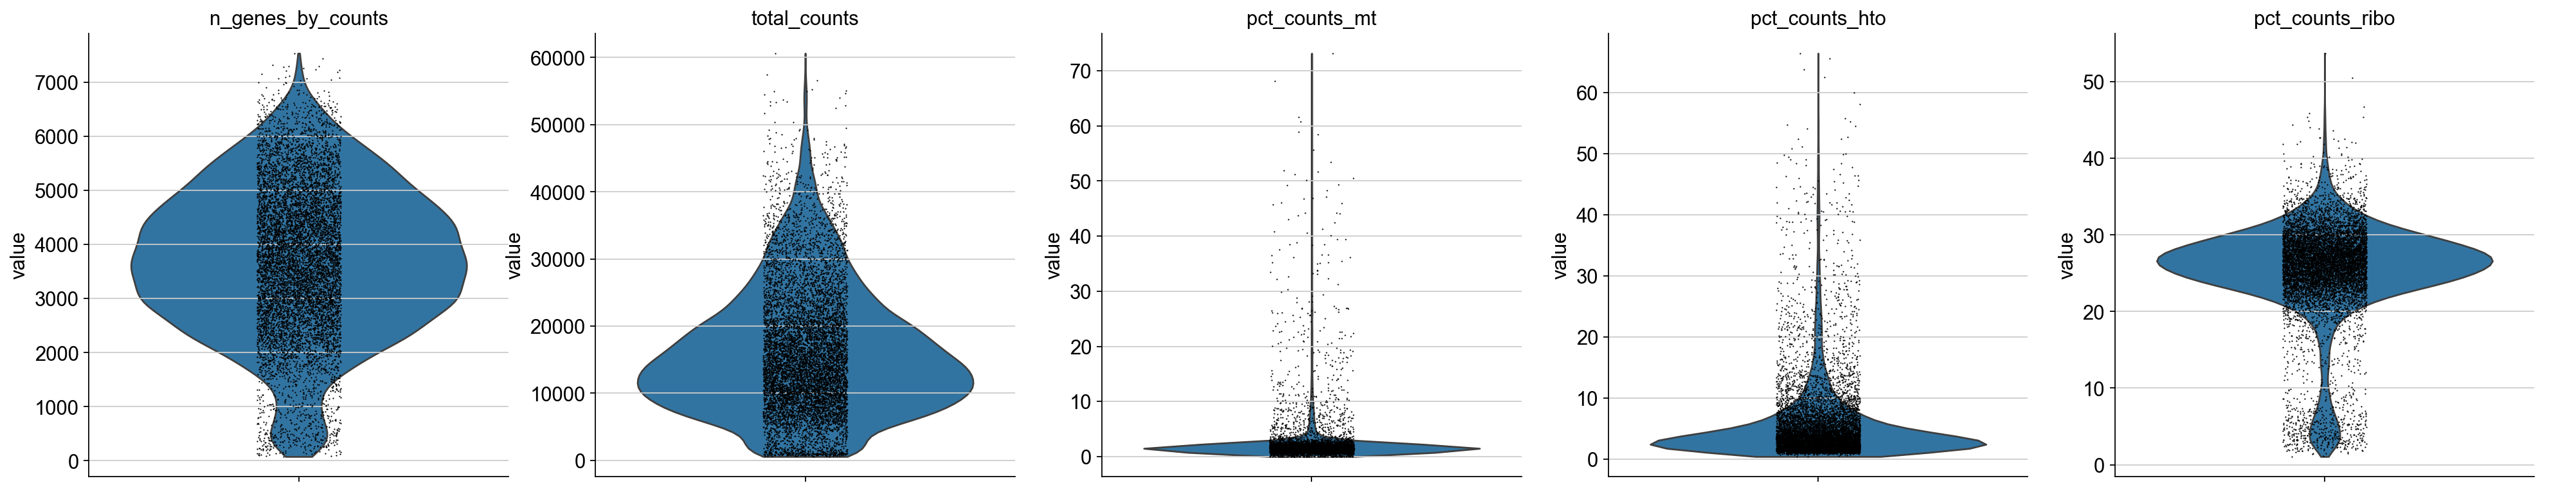

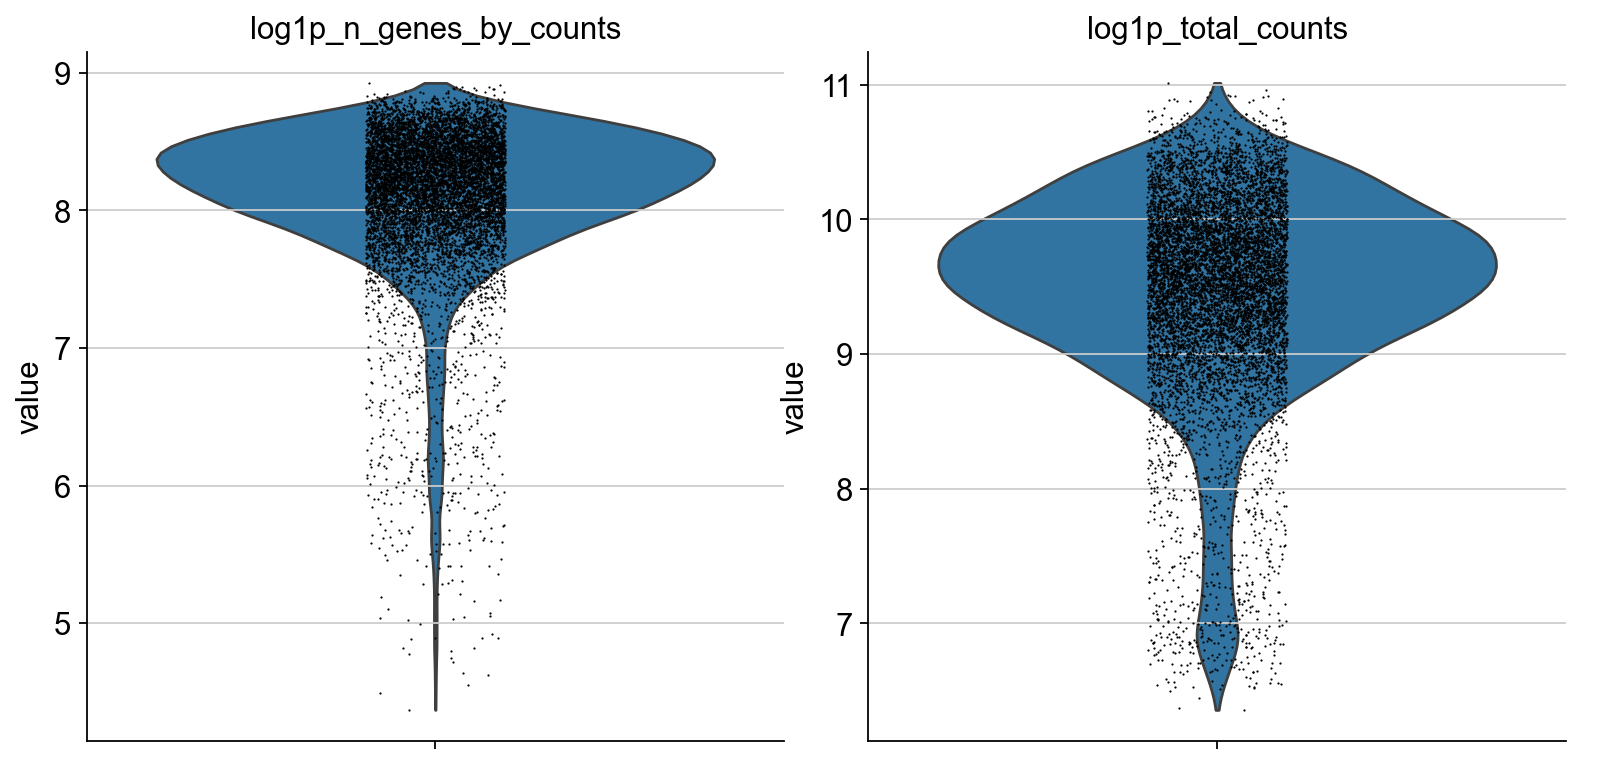

In [179]:
#plot qc metrics, based on this you can decide on what to filter
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_hto','pct_counts_ribo'], multi_panel=True)
sc.pl.violin(adata, ['log1p_n_genes_by_counts', 'log1p_total_counts'], multi_panel=True)

In [172]:
#find outliers in the gene/total counts via MAD
adata.obs["outlier"] = (
    dp.is_mad_outlier(adata, "log1p_total_counts", 5)
    |  dp.is_mad_outlier(adata, "log1p_n_genes_by_counts", 5)
    |  dp.is_mad_outlier(adata, "pct_counts_in_top_20_genes", 5)
    |  dp.is_mad_outlier(adata, "pct_counts_mt", 10) 
    |  (adata.obs["pct_counts_mt"] > 10)
)
adata.obs.outlier.value_counts()

outlier
False    8216
True      808
Name: count, dtype: int64

In [173]:
adata_mad = adata.copy()
adata_mad = adata_mad[(~adata_mad.obs.outlier)]
adata_mad

View of AnnData object with n_obs × n_vars = 8216 × 20264
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hto', 'log1p_total_counts_hto', 'pct_counts_hto', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hto', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

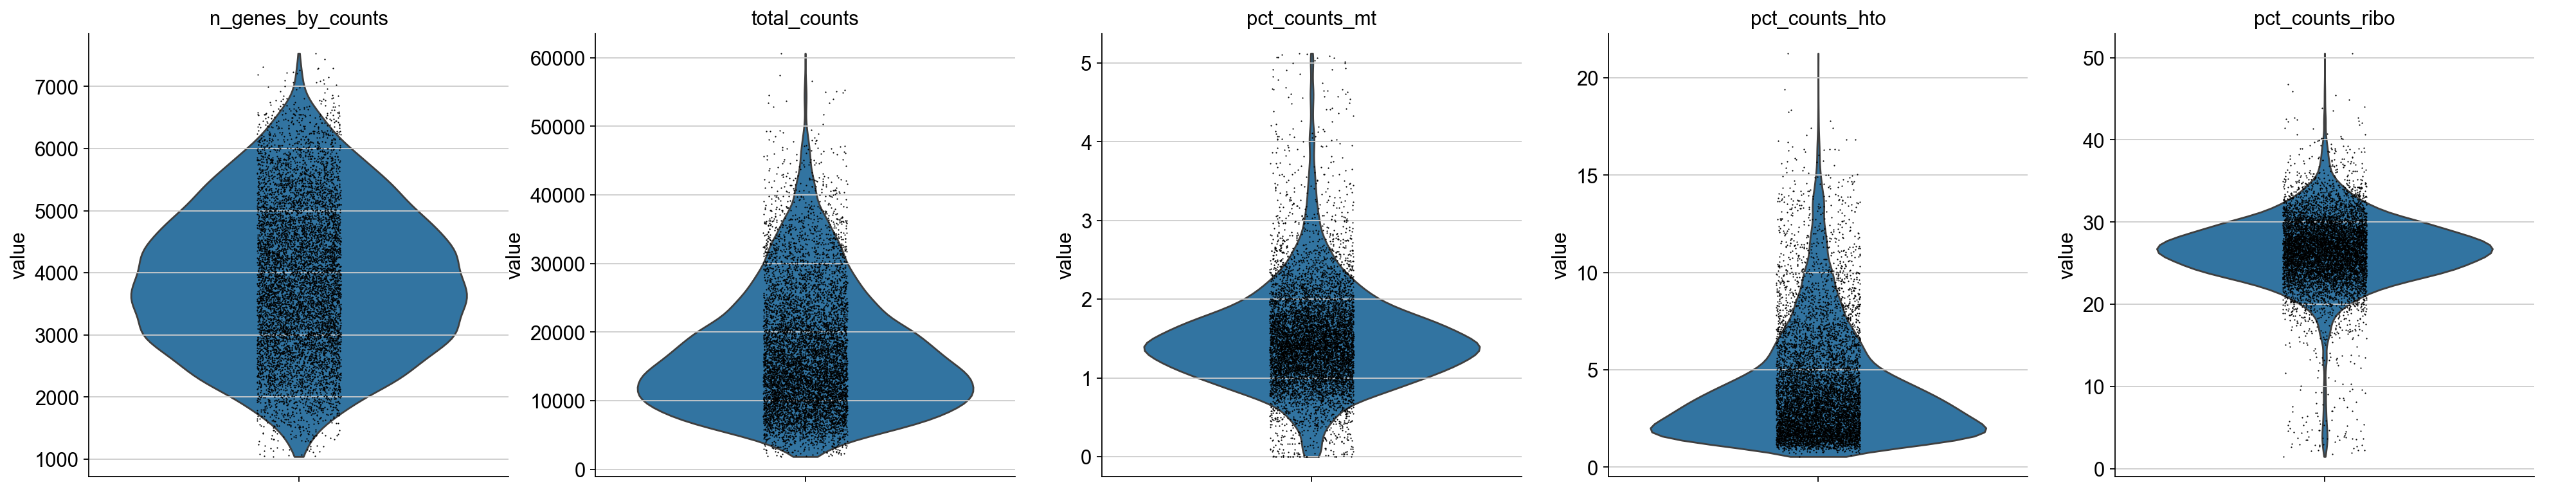

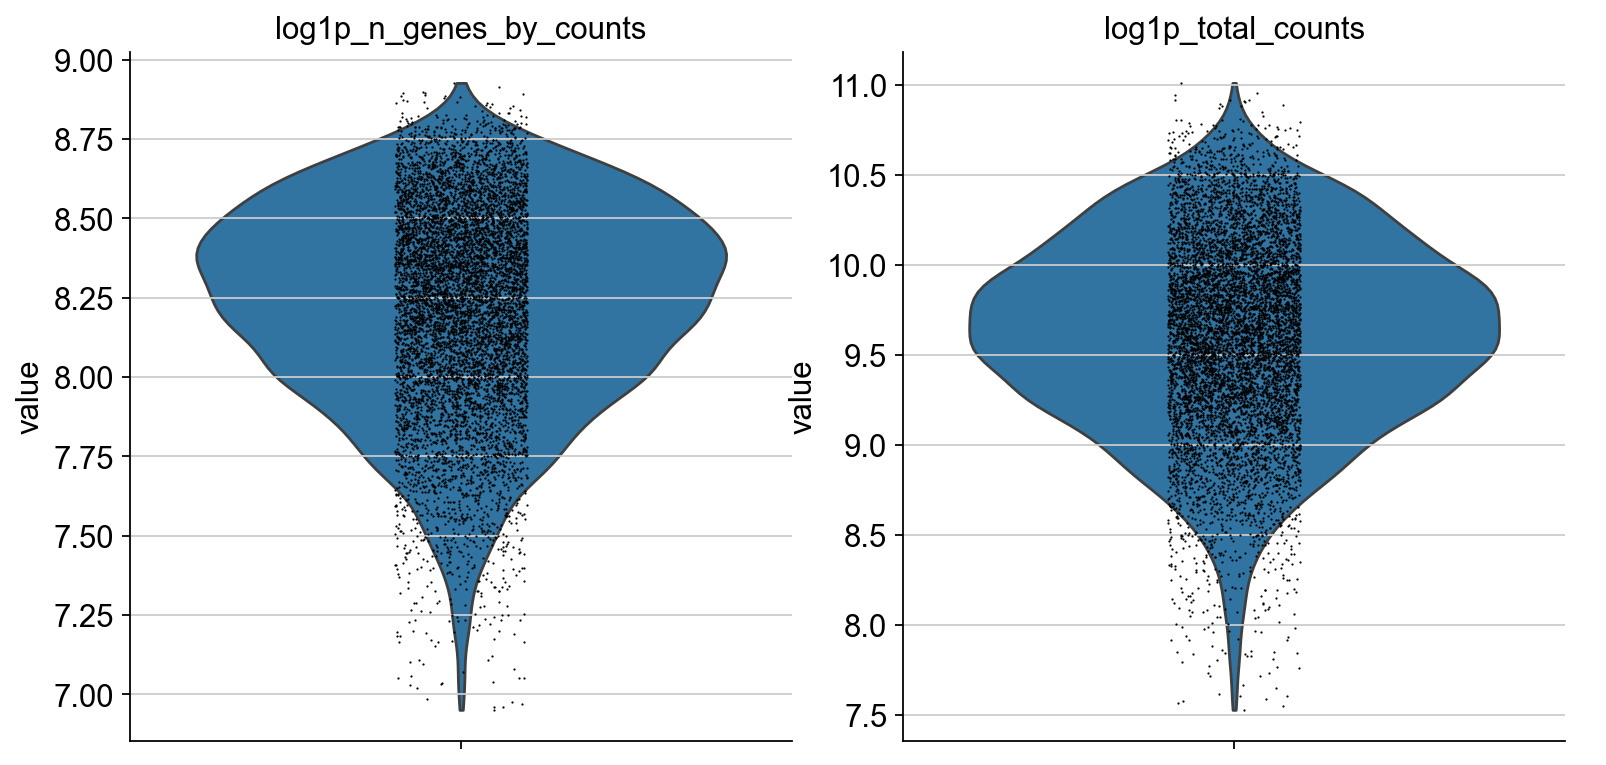

In [180]:
sc.pl.violin(adata_mad, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_hto','pct_counts_ribo'], multi_panel=True)
sc.pl.violin(adata_mad, ['log1p_n_genes_by_counts', 'log1p_total_counts'], multi_panel=True)

In [175]:
adata.obs["outlier"] = (
    dp.is_qntl_outlier(adata, "log1p_total_counts", .01)
    |  dp.is_qntl_outlier(adata, "log1p_n_genes_by_counts", .01)
    |  dp.is_qntl_outlier(adata, "pct_counts_in_top_20_genes", .01)
    |  dp.is_qntl_outlier(adata, "pct_counts_mt", .01)
    |  (adata.obs["pct_counts_mt"] > 8)
)
adata.obs.outlier.value_counts()

outlier
False    8365
True      659
Name: count, dtype: int64

In [176]:
adata_pctl = adata.copy()
adata_pctl = adata_pctl[ (~adata_pctl.obs.outlier)]
adata_pctl

View of AnnData object with n_obs × n_vars = 8365 × 20264
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hto', 'log1p_total_counts_hto', 'pct_counts_hto', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hto', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

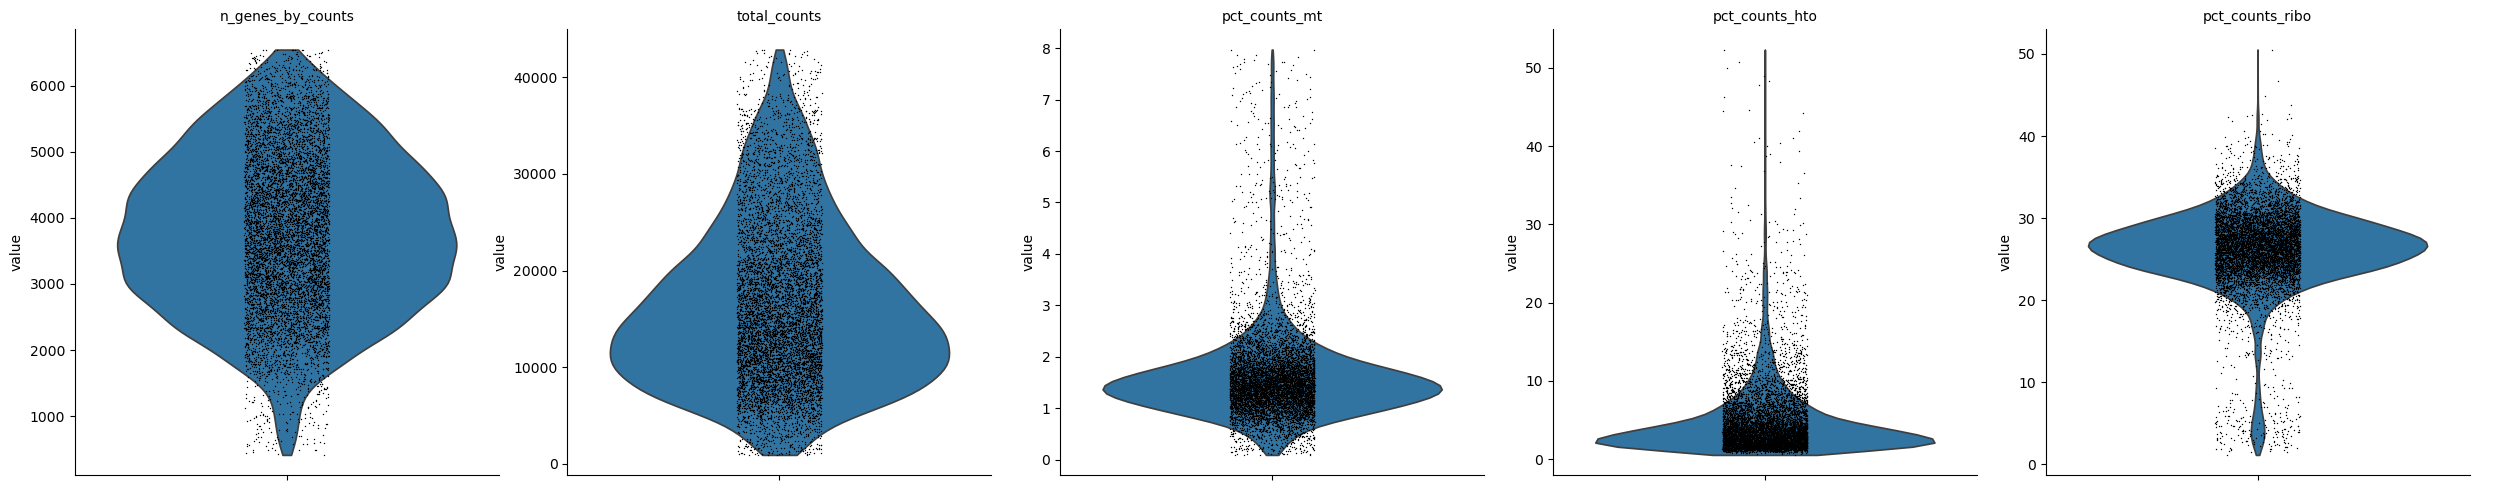

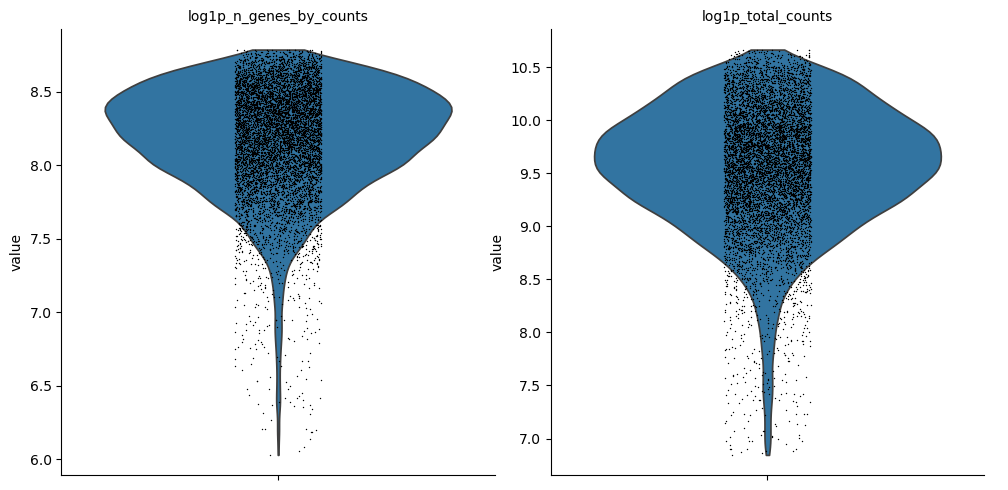

In [177]:
sc.pl.violin(adata_pctl, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_hto','pct_counts_ribo'], multi_panel=True)
sc.pl.violin(adata_pctl, ['log1p_n_genes_by_counts', 'log1p_total_counts'], multi_panel=True)